### APPLIED MATHEMATICAL CONCEPTS FOR DEEP LEARNING
### ChatDoctor project
---
</span><span style="font-size: 22px;">
Chaoyu Liu<br>
Eric Lessa<br>
Moossa Hussain<br>
Pranav Gupta<br>
Sam	Emami<br>
Shrey Patel<br>
</span>

## **Index**

1. **Dataset Details**
   
2. **Exploratory Data Analysis (EDA)**
   - Explanation of the t-SNE Plot  
     1. Presence of Visible Clusters  
     2. Variation in Density  
     3. No Clear Separation of Distinct Groups

3. **Fine-tuning pre-trained model (t5-small)**

4. **Track Loss and Accuracy using Tensor Board**

5. **Deploy the model as a RAG application**

6. **Execution (Function Calls)**

7. **Gradio Interface**

8. **Individual Learning**


## 1. Dataset Details

This dataset is formed from three different data sources used in the **ChatDoctor** project:

### Sources:
- **HealthCareMagic-100k**: 100,000 real conversations between patients and doctors from [HealthCareMagic.com](https://www.healthcaremagic.com/)
- **iCliniq-10k**: 10,000 real conversations between patients and doctors from [iCliniq.com](https://www.icliniq.com/)
- **GenMedGPT-5k**: 5,000 generated conversations between patients and physicians from ChatGPT and a disease database
  *(This dataset was not included due to being AI-generated. However, it can be manually added if desired.)*

### Dataset Link:
[Hugging Face Repository](https://huggingface.co/datasets/avaliev/chat_doctor?row=99)

---

## Sample Data:

```json
{
  "instruction": "If you are a doctor, please answer the medical questions based on the patient's description.",
  "input": "I woke up this morning feeling the whole room is spinning when I was sitting down. I went to the bathroom walking unsteadily, as I tried to focus I felt nauseous. I tried to vomit but it wouldn’t come out. After taking Panadol and sleeping for a few hours, I still feel the same. By the way, if I lay down or sit down, my head does not spin—only when I move around do I feel the whole world spinning. And is it normal to have stomach discomfort at the same time? Earlier, after I relieved myself, the spinning lessened, so I am not sure whether it's connected or just a coincidence. Thank you, doc!",
  "output": "Hi, Thank you for posting your query. The most likely cause of your symptoms is **Benign Paroxysmal Positional Vertigo (BPPV)**, a type of peripheral vertigo. The most common symptom is dizziness or giddiness, which worsens with movement. Accompanying nausea and vomiting are common. The condition is due to a problem in the ear and usually improves on its own within a few days. **Betahistine tablets** may help relieve your symptoms. Performing **vestibular rehabilitation** or adaptation exercises can prevent recurrence. An **ENT evaluation** is also recommended. I hope this helps. Best wishes, *Chat Doctor*."
}


In [1]:
!pip install -U langchain langchain-community faiss-cpu datasets sentence-transformers transformers accelerate torch torchvision torchaudio
!pip install bitsandbytes peft
!pip install gradio --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 51.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 86.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/8

### Huggingface Login using HF Token

In [ ]:
import os
os.environ["HUGGINGFACE_TOKEN"] = "yourHFtoken"
!huggingface-cli login --token $HUGGINGFACE_TOKEN


In [3]:
import wandb

import os

#wandb.finish()

# Set your API key from wandb
os.environ["WANDB_API_KEY"] = "your api key"

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ericrlessa (ericrlessa-george-brown-college). Use `wandb login --relogin` to force relogin


True

In [4]:
wandb.init(
    settings=wandb.Settings(init_timeout=120),
    project="final_t5_chatdoctor"
)

### 2. Exploratory Data Analysis (EDA)

 Loading dataset...


README.md:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

train.json:   0%|          | 0.00/120M [00:00<?, ?B/s]

validation.json:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/95588 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11949 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


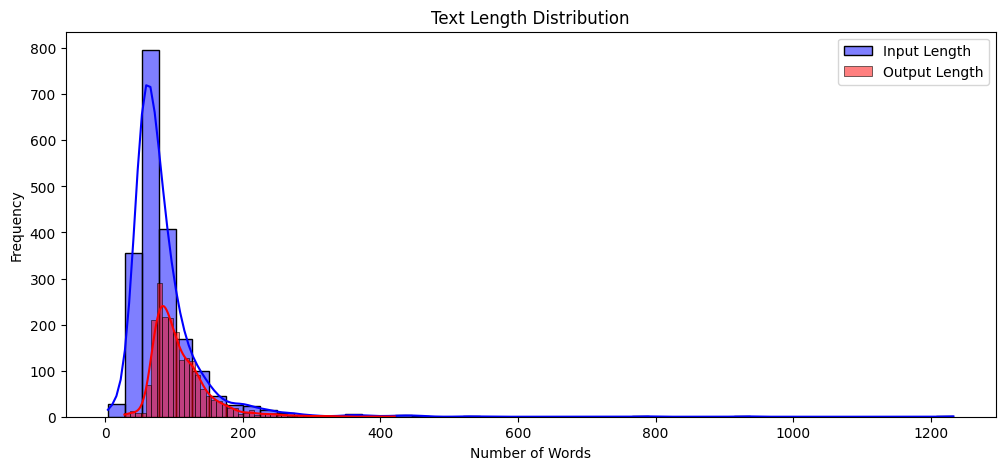

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


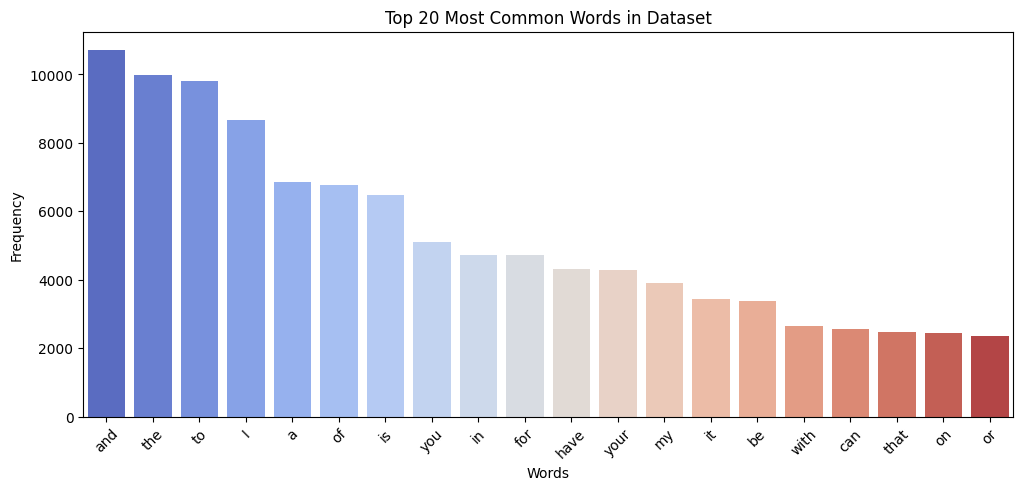

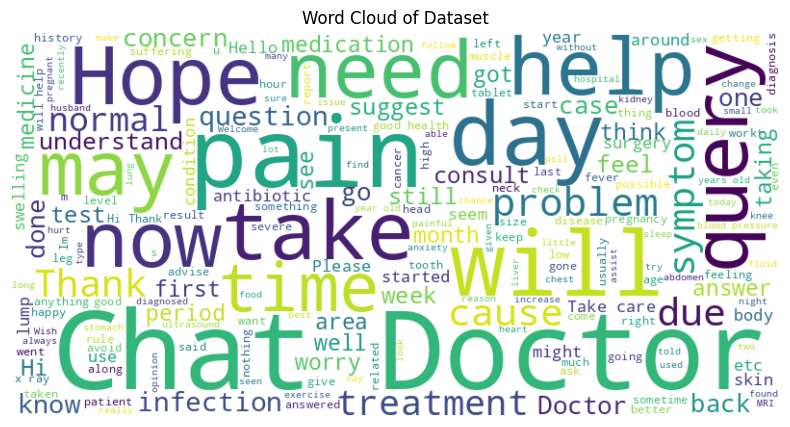


 Generating text embeddings for visualization...


<ipython-input-5-d0ee3f8fb956>:77: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

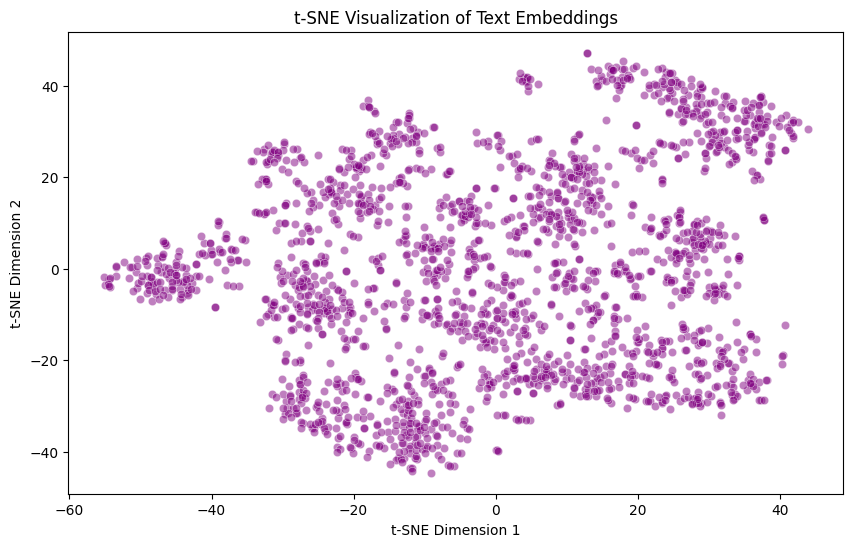


 EDA Completed!


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from datasets import load_dataset
import numpy as np
from sklearn.manifold import TSNE
from langchain_community.embeddings import HuggingFaceEmbeddings

def exploratory_data_analysis():

    """
    Performs exploratory data analysis (EDA) on the "Chat Doctor" dataset.

    This function loads the dataset, visualizes text length distributions,
    analyzes word frequencies, generates a word cloud, and performs t-SNE
    visualization of text embeddings.

    Steps:
    1. Loads and samples 2,000 rows for efficient visualization.
    2. Computes text length distributions and plots histograms.
    3. Analyzes word frequencies and visualizes the top 20 most common words.
    4. Generates a word cloud from the dataset.
    5. Generates sentence embeddings using a pre-trained MiniLM model.
    6. Applies t-SNE dimensionality reduction to visualize embeddings.

    Returns:
        None: Displays multiple plots and prints EDA completion message.
    """

    print(" Loading dataset...")
    dataset = load_dataset("avaliev/chat_doctor")
    df = pd.DataFrame(dataset["train"])

    # Sample Data (Only 2K rows for efficiency in visualization)
    df = df.sample(n=2000, random_state=42)
    df["combined_text"] = df["input"] + " " + df["output"]

    # Word count distributions
    df["input_length"] = df["input"].apply(lambda x: len(str(x).split()))
    df["output_length"] = df["output"].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(12, 5))
    sns.histplot(df["input_length"], bins=50, kde=True, color="blue", label="Input Length")
    sns.histplot(df["output_length"], bins=50, kde=True, color="red", label="Output Length")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title("Text Length Distribution")
    plt.legend()
    plt.show()

    # Word frequency analysis
    all_words = " ".join(df["combined_text"].astype(str))
    word_counts = Counter(all_words.split())
    common_words = word_counts.most_common(20)

    words, counts = zip(*common_words)
    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(words), y=list(counts), palette="coolwarm")
    plt.xticks(rotation=45)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title("Top 20 Most Common Words in Dataset")
    plt.show()

    # Generate a Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Dataset")
    plt.show()

    # Generate Embeddings for Visualization
    print("\n Generating text embeddings for visualization...")
    embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    embeddings = embed_model.embed_documents(df["combined_text"].tolist())

    # Convert list of embeddings to NumPy array for t-SNE
    embeddings_array = np.array(embeddings)

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(embeddings_array)

    # Plot t-SNE results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], alpha=0.5, color="purple")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization of Text Embeddings")
    plt.show()

    print("\n EDA Completed!")

exploratory_data_analysis()


# Explanation of the t-SNE Plot

## What This t-SNE Plot Represents

- Each **point** represents a **medical QA pair** (question + answer).
- **Closer points** indicate **semantic similarity**, meaning the medical questions or answers are related.
- **Farther apart points** belong to **different topics or clusters**.

---

## Key Observations from the t-SNE Plot

### a. Presence of Visible Clusters  
- **Certain medical topics naturally group together.**  
- Similar questions (e.g., related to **diabetes, hypertension, or respiratory diseases**) form clusters with similar embeddings.

### b. Variation in Density  
- **Densely packed regions** → Frequently occurring medical topics in your dataset.  
- **Loosely packed or isolated points** → Rare or outlier topics that don’t fit well with others.

### c. No Clear Separation of Distinct Groups  
- **t-SNE works well in high-dimensional spaces**, but its projections aren’t always perfectly separable.  
- This suggests a **mix of overlapping medical topics** rather than strictly distinct categories.



### 3. Fine-tuning pre-trained model (t5-small)

In [9]:
import torch
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq

class ChatDoctorFineTuner:

    """
        A fine-tuning pipeline for training a T5-based model to generate medical responses.
    """

    def __init__(self, model_name="t5-small"):
        """
            Initializes the fine-tuner with a pre-trained T5 model and tokenizer.
        
            :param model_name: Name of the pre-trained model (default: "t5-small")
        """
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        self.trainer = None
        self.tokenized_datasets = None
        self.dataset = None

    def prepare_data(self, dataset_name="avaliev/chat_doctor"):
        """
        Loads and tokenizes the dataset for fine-tuning.
        
        :param dataset_name: Hugging Face dataset identifier (default: "avaliev/chat_doctor")
        """        
        self.dataset = load_dataset(dataset_name)
        #self.dataset["train"] = self.dataset["train"].select(range(500))
        self.tokenized_datasets = self.dataset.map(self.preprocess_function, batched=True, remove_columns=self.dataset["train"].column_names)


    def preprocess_function(self, examples):
      """
      Prepares input-output pairs for training by formatting them properly.
       
      :param examples: Batch of dataset examples
      :return: Tokenized inputs and labels
      """
      # Format the input with a task-specific prefix
      inputs = [f"As a doctor, respond to the following patient's medical question: {input_text}" for input_text in examples["input"]]
      targets = examples["output"]

      # Tokenize inputs and targets
      model_inputs = self.tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
      labels = self.tokenizer(targets, max_length=512, truncation=True, padding="max_length")

      # Add labels to the model inputs
      model_inputs["labels"] = labels["input_ids"]
      return model_inputs

    def fine_tune(self):
      """
      Fine-tunes the model using the prepared dataset.
      """
      #  Training Arguments
      training_args = TrainingArguments(
          output_dir="./fine_tuned_chat_doctor",
          evaluation_strategy="epoch",
          per_device_train_batch_size=8,  #  Larger batch size since T5 is small
          per_device_eval_batch_size=8,
          num_train_epochs=3,  #  More epochs since training is faster
          save_strategy="epoch",
          logging_dir="./logs",
          logging_steps=10,
          report_to="all"
      )

      data_collator = DataCollatorForSeq2Seq(self.tokenizer, model=self.model)

      trainer = Trainer(
        model=self.model,
        args=training_args,
        train_dataset=self.tokenized_datasets["train"],
        eval_dataset=self.tokenized_datasets["validation"],
        tokenizer=self.tokenizer,
        data_collator=data_collator
      )

      # Train model
      print("\nStarting training...")
      try:
          trainer.train()
          print("\nTraining completed successfully!")
      except Exception as e:
          print(f"\nError during training: {str(e)}")
          return

      self.trainer = trainer

    def evaluate_model(self):
      """
      Evaluates the fine-tuned model on the test dataset.
      """
      # Evaluate Model
      metrics = self.trainer.evaluate(self.tokenized_datasets["test"])
      print(f" Evaluation Metrics: {metrics}")

    def save_model(self, path = "./fine_tuned_chat_doctor"):
      """
      Saves the fine-tuned model and tokenizer.
        
      :param path: Directory to save the model (default: "./fine_tuned_chat_doctor")
      :return: Path where the model is saved
      """
      self.trainer.save_model(path)
      self.tokenizer.save_pretrained(path)
      return path

    def predict(self, input_text):
        """
        Generates a medical response for a given question.
        
        :param input_text: The medical question
        :return: The generated response
        """
        # Structured input format
        formatted_input = f"Instruction: If you are a doctor, please answer the medical questions based on the patient's description.\n\nQuestion: {input_text}\n\nAnswer:"
    
        # Tokenize input
        inputs = self.tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    
        # Generate response with better control
        output_ids = self.model.generate(
            **inputs,
            max_length=300,  #  Increased length to prevent truncation
            min_length=30,  #  Ensures full response
            num_beams=6,  # Increased for better diversity
            no_repeat_ngram_size=4,  #  Prevents repeating 4-word phrases
            repetition_penalty=2.3,  # Stricter repetition control
            early_stopping=True,  #  Stops at natural end
            temperature=0.7,  #  Slight randomness for better flow
            top_k=40,  #  Keeps diversity but prevents random noise
            top_p=0.85,  # Nucleus sampling for more controlled output
            length_penalty=0.9  # Avoids cutting off responses too soon
        )
    
        response = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
        return response


#### Instantiate the class and download dataset

### 4. Track Loss and Accuracy using Tensor Board

In [10]:
import os
from torch.utils.tensorboard import SummaryWriter

def track_training(fine_tuner):
    """
    Logs training and evaluation loss metrics to TensorBoard.

    :param fine_tuner: An instance of ChatDoctorFineTuner with a trained model.
    """
    
    log_dir = "./logs"
    os.makedirs(log_dir, exist_ok=True)

    writer = SummaryWriter(log_dir)

    for epoch, metrics in enumerate(fine_tuner.trainer.state.log_history):
        if "loss" in metrics:
            writer.add_scalar("Loss/train", metrics["loss"], epoch)
        if "eval_loss" in metrics:
            writer.add_scalar("Loss/eval", metrics["eval_loss"], epoch)

    writer.close()
    print("Training progress logged in TensorBoard!")



### 5. Deploy the model as a RAG application

In [11]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
import pandas as pd
from datasets import load_dataset
import torch

class VectorStore:
    """
    A vector-based retrieval system for improving medical question answering
    using FAISS and a fine-tuned T5 model.
    """

    def __init__(self, fine_tuner):
        """
        Initializes the vector store with a fine-tuned model.

        :param fine_tuner: An instance of ChatDoctorFineTuner
        """
        self.fine_tuner = fine_tuner
        self.embed_model = None
        self.retriever = None

    def store_dataset_embedded(self):
        """
        Creates a FAISS vector store by embedding the dataset.
        """
        df = pd.DataFrame(fine_tuner.dataset["train"])
    
        #  Combine input and output for FAISS
        df["combined_text"] = df["input"] + " " + df["output"]
    
        # Load FAISS Embeddings
        print(" Loading FAISS Embeddings...")
        self.embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    
        #  Compute embeddings for FAISS
        print(" Computing embeddings for FAISS...")
        vectorstore = FAISS.from_texts(df["combined_text"].tolist(), self.embed_model)
    
        # Save & Load FAISS Index
        vectorstore.save_local("faiss_index")
        print(" FAISS index saved successfully!")
        
    def initiate_retriever(self):
        """
        Loads the FAISS vector store for retrieving relevant documents.
        """
        print(" Loading FAISS Vector Store...")
        vectorstore = FAISS.load_local("faiss_index", self.embed_model, allow_dangerous_deserialization=True)
    
        self.retriever = vectorstore.as_retriever()
    
    def predict(self, question):
        """
        Retrieves relevant context from FAISS and generates an answer.

        :param question: The medical question to be answered
        :return: Generated response from the fine-tuned model
        """
        docs = self.retriever.get_relevant_documents(question)
        context = " ".join([doc.page_content for doc in docs])

        # Format input for the model
        formatted_question = f"{context}\n\nQuestion: {question}\n\nAnswer:"

        # Generate response using fine-tuned model
        response = fine_tuner.predict(formatted_question)

        return response

## 6. Execution (Function calls)
---
### Phase 1:
- Fine-Tuning the Model.
- Saving and downloading the fine-tuned version.

In [12]:
# Phase 1: Fine-Tune Model
fine_tuner = ChatDoctorFineTuner()
fine_tuner.prepare_data()
fine_tuner.fine_tune()
fine_tuner.save_model()

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/95588 [00:00<?, ? examples/s]

Map:   0%|          | 0/11949 [00:00<?, ? examples/s]

Map:   0%|          | 0/11949 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-e76db62bdef8>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.016700,0.939741
2,0.941300,0.906268
3,0.924600,0.897497


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Training completed successfully!


'./fine_tuned_chat_doctor'

---
### Phase 2:
- Track Training using Tensor Board.
- Evaluate model on Test Dataset
- Plot Graph Training and Evaluation Loss Curve
- Make Prediction
-[Sample Questions for Prediction: "What are the symptoms of diabetes?", "How can I manage high blood pressure?", "What are the treatments for asthma?"]

In [13]:
# Track Training
track_training(fine_tuner)

Training progress logged in TensorBoard!


In [14]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs --host 0.0.0.0 --port 6006

<IPython.core.display.Javascript object>

In [15]:
# Model Evaluation
fine_tuner.evaluate_model()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


 Evaluation Metrics: {'eval_loss': 0.8997295498847961, 'eval_runtime': 275.3767, 'eval_samples_per_second': 43.391, 'eval_steps_per_second': 2.713, 'epoch': 3.0}


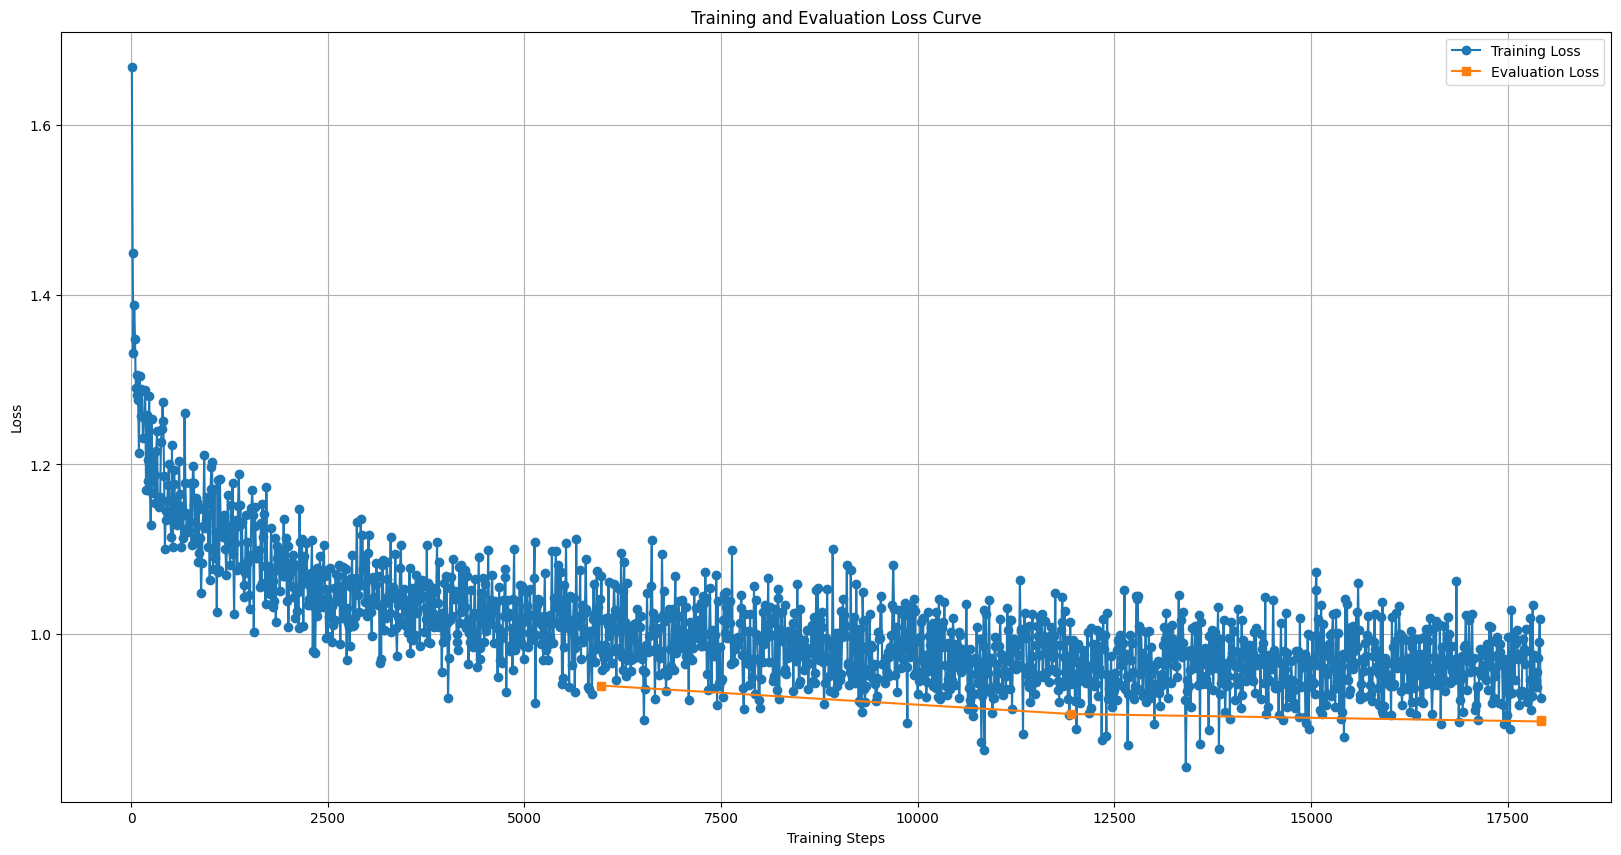

In [32]:
# Plotting Graph (Training Loss, Evaluation Loss)
import matplotlib.pyplot as plt

def plot_training_metrics(trainer):
    """
    Plots training loss and evaluation loss from Trainer's log history.
    """
    # Extract loss values from trainer logs
    log_history = trainer.state.log_history

    # Separate training loss and evaluation loss
    steps = []
    eval_steps = []
    train_losses = []
    eval_losses = []

    for entry in log_history:
        if "loss" in entry:
            train_losses.append(entry["loss"])
            steps.append(entry["step"])
        if "eval_loss" in entry:
            eval_steps.append(entry["step"])
            eval_losses.append(entry["eval_loss"])

    # Plot Training and Evaluation Loss
    plt.figure(figsize=(20, 10))
    plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss", marker="o")
    if eval_losses:
        plt.plot(eval_steps[:len(eval_losses)], eval_losses, label="Evaluation Loss", marker="s")

    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_metrics(fine_tuner.trainer)

In [38]:
# Make Predictions
fine_tuner.predict("What are the symptoms of diabetes?")

'Thanks for your question on Chat Doctor. I can understand your concern. Diabetes is a common cause of diabetes. You need to consult a gastroenterologist and get an ultrasound done to rule out the type of diabetes you are having. Then you should take treatment accordingly. Hope I have solved your query. I will be happy to help you further. Wish you good health. Thanks.'

<ipython-input-11-bd5588f294a5>:62: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = self.retriever.get_relevant_documents(question)
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.85` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to

---
### Phase 3:
- Deploy the fine-tuned model as a RAG application.
- Gradio Interface as a front-end, for Client Interaction

In [34]:
# Deploy the Model

def create_vector_store(fine_tuner):
    vector_store = VectorStore(fine_tuner)
    vector_store.store_dataset_embedded()
    vector_store.initiate_retriever()
    return vector_store


### 7. Gradio interface

In [35]:
import gradio as gr

def gradio_interface(fine_tuner):
    """
    Launches a Gradio-based interface for the Medical QA Bot.

    This function initializes and deploys a fine-tuned T5-based chatbot using Gradio.
    It allows users to input medical-related questions and receive AI-generated responses.

    The function performs the following steps:
    1. Deploys the fine-tuned model via `deploy_fine_tuned_model()`.
    2. Defines a chat function that takes user input and retrieves model responses.
    3. Creates an interactive Gradio UI with a text input and output box.
    4. Launches the Gradio interface with a public link.

    Returns:
        None: The function launches the Gradio interface and does not return a value.

    Example:
        To start the chatbot UI, simply call:

        >>> gradio_interface()

        This will display an interactive web UI where users can input medical queries.
    """

    # Deploy the fine-tuned model (loads the `qa_bot` function)
    qa_bot = create_vector_store(fine_tuner)

    # Define Gradio function to interact with the bot
    def chat_function(user_input):
        """
        Generates a response from the fine-tuned model based on user input.

        Args:
            user_input (str): The medical question entered by the user.

        Returns:
            str: The chatbot-generated response.
        """
        response = qa_bot.predict(user_input)
        return response

    # Create Gradio UI
    interface = gr.Interface(
        fn=chat_function,  # Function to call
        inputs=gr.Textbox(lines=2, placeholder="Enter your medical question..."),
        outputs=gr.Textbox(),
        title=" Medical ChatBot (T5 Fine-Tuned)",
        description="Ask medical-related questions and get answers from the fine-tuned T5 model!",
        theme="default"
    )

    # Launch the UI
    interface.launch(share=True)  # Use `share=True` to get a public link
# start the Gradio UI
gradio_interface(fine_tuner)


 Loading FAISS Embeddings...
 Computing embeddings for FAISS...
 FAISS index saved successfully!
 Loading FAISS Vector Store...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9fd5b95f6cc522f1d5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### 8. Individual Learning:

### Chaoyu Learning -
---

Using LLMs (distilbert, distilgpt2) on local machine requires enough GPU memory to accomodate both the model and input tensors.

Using the `nvidia-smi` command, we can see the GPU utilization:

```nvidia-smi``` output:

```
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0  On |                  N/A |
|  0%   56C    P8             38W /  420W |     444MiB /  24576MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|    0   N/A  N/A     22796      G   /usr/bin/gnome-shell                          131MiB |
|    0   N/A  N/A     23699      G   /usr/lib64/firefox/firefox                    196MiB |
|    0   N/A  N/A     24135    C+G   /usr/bin/ptyxis                                55MiB |
|    0   N/A  N/A     24246      G   /usr/bin/Xwayland                               6MiB |
+-----------------------------------------------------------------------------------------+
```

To avoid overruning GPU memory, we can increase the batch size incrementally in powers of 2.

To estimate the memory consumption without trial-and-error, we can also multiply the input tensor shape with the tensor dtype. For example, if the input tensor size is $(1000, 128)$, and the dtype is float32, the estimated memory usage for that tensor would be $512000$ bytes.

However, it's important to experiment with the deep learning library first to get a sense of its memory allocation behaviour. From our experience, both tensorflow and pytorch tends to allocate memory in bulk, so the memory consumption growth as data is loaded looks like a step function rather than a linear one.

In practice, one should also take manual memory management into consideration when writing pipeline code. Any tensor loaded into GPU would not be released until it's manually moved out of GPU or deleted. The same applies to RAM, where batch loading and batch saving is crucial when input/output dataset is large.

Some memory management practices to help increase utilization and avoid waste:
- Use well-established dataset loading and saving libraries (tensorflow Dataset, pytorch data loader, huggingface dataset).
- Ensure batch processing (instead of everything at once) whenever possible.
- Only move tensors to GPU when needed.
- delete python variables when not needed anymore, eg. `var = None`, so that python garbage collection can free the memory automatically.

### Eric's Learning -
---

The process over these weeks has been very enriching, allowing me to explore different technologies, environments, and APIs. Starting with little knowledge about LLMs, the first step was an attempt to create a Transformer from scratch, but I quickly realized that this was not the right approach. Exploring the existing solutions and Hugging Face, I now have a better understanding of what is being called the implementation era of AI. It represents a high level of productivity in development, with techniques and solutions available to everyone. The possibilities provided by the current stage of Machine Learning development are immense.

#### LLM
- Explored many LLM models in hugging faces: BERT (and many models derived from it), gpt2, R1, T5
- There are many LLM model options, varying in size, architecture, use case focus, and efficiency.
- The productivity LLM models offers is incredible.

#### Hugging Faces
- Working with Hugging Face was a great way to understand the ecosystem of machine learning solutions.
- The example below shows how effective the environment is for fine-tuning a model and pushing it to your Hugging Face account.
- The models are stored in a git repository. Can be as "simple" as 8 files. The binary file with the parameters can be large. So, should be used 'git lfs install' to be able to push to the repo in your account in hugging faces.

In [ ]:
from transformers import pipeline

generator = pipeline("summarization", model="Eric-Lessa/t5_chatbot_doctor")

def generate_response(question):
  result = generator("generate response" + question, max_length=500)
  print(result)

generate_response("I have started to get lots of acne on my face, particularly on my forehead. Please help me.")

#### AWS Sage Maker
- Deploying a model on a cloud provider can be highly efficient and scalable.
- Cloud deployment makes model deployment easy and effective.
- Containers are a core technology for machine learning environments, whether for prediction or training.
- S3 can be used to store the model. Basically, after train the model, you compact the files as .tar and upload to a S3 bucket. You could for example, just clone a repo in Hugging faces, compact the files and upload to S3. After that, you can use any service you want to use the model.
- Cloud providers offer a wide range of services, from high-level offerings to low-level services with various types of GPUs, machines, and environments that can be used for training and inference.

### Dataset
- The first attempt to the project was to create a python assistant.
- I preprocessed the StackOverflow posts dataset with 58 million rows, selecting the best answer (highest score) for each Python-related question, and reduced the dataset to 18k rows.
- I tried gpt 2 to fine tune the model, but the results were not satisfactory. The model shouln't be large because of limitations with resources available to training.
- Using RAG, I tried to use pdfs of python tutorials in the internet but the data was poor.
- The experience highlights the importance of the dataset in building the solution.

### Moossa's Learning
---

#### Understanding Resource & Time Constraints
- Large models like **Mistral-7B-OpenOrca** require significant resources.  
- Training **just 1,000 samples for 1 epoch with QLoRA optimization** took over **3 hours**.  
- Could not complete training due to high resource demands, leading to a switch to **T5-small** for efficiency.

#### Importance of Exploratory Data Analysis (EDA)
- EDA is crucial before model fine-tuning to understand the dataset.  
- Key insights like **context length** directly impact model learning.  
- If text length exceeds the model's limit, **important information may be lost**.  
- Different models have different **context window sizes**, so selection matters.

#### Impact of Hyperparameter Tuning
- Hyperparameter tuning plays a major role in:
  - Training time  
  - Model convergence  
  - Performance improvement  
- Small changes can significantly alter computation time and results.

#### Implementing a RAG-Based Solution with LangChain
- **LangChain** provides a structured approach to building RAG applications.  
- Explored:
  - **Vector Databases**
  - **Similarity Search**
  - **Retrieval Algorithms**  
- Understood how RAG helps **retrieve relevant context** before generating responses.

#### Interactive UI Development
- Implemented a **simple front-end** using **Gradio**, enabling an interactive chatbot experience.  
- **Gradio** makes it easy to deploy **LLM-based applications** without heavy frontend development.

#### Key Takeaways on Resource Optimization
- **Computational resources are the biggest constraint** in model training.  
- Techniques like **LoRA, QLoRA (4-bit optimization)** help reduce memory consumption while maintaining efficiency.  
- **Choosing the right model & training approach** depends on the specific **use case** and available compute.

#### Utilizing Free GPU Resources
- Used **Google Colab & Kaggle** for free GPU access.  
- **Preferred Kaggle** over Colab due to **session timeout issues** in Colab.  

#### Model Saving & Reusability
- **Saving the fine-tuned model** is crucial for:
  - Avoiding redundant training
  - Optimizing resource utilization
  - Deploying models efficiently without re-training

#### RAG & AI Hallucination
- **RAG helps LLMs generate more context-specific responses**, reducing hallucination.  
- However, **RAG alone cannot fully eliminate AI hallucination**—further refinements and filtering mechanisms are needed.


### Pranav's Learning -
---

### 1. Medical Domain Specificity: The project highlighted unique challenges in medical AI through several key observations:

#### Adaptation Challenges:

- Medical communication requires extreme precision - a single misinterpreted term could have significant consequences
- The project demonstrated that domain-specific fine-tuning is not just an optimization, but a necessity for medical applications

#### Other Insights & Recommendations: 
- Focus on maintaining clinical accuracy while developing the QA bot
- Recognize that medical language involves complex, context-dependent communication patterns that generic models cannot inherently understand
- Acknowledge that RAG helps reduce hallucination, but does not eliminate domain-specific challenges

### 2. Platform and Infrastructure: The project provided practical insights into cloud-based machine learning environments like AWS Sagemaker. Also, Gradio is a great tool for creating interactive UI for AI applications and is easy to implement with the hugging face library. Migrating from Mistral 7B to T5 small was a good move for resource constraint learning. Integration of multiple technologies (FAISS, LangChain, Hugging Face Embeddings) to create a cohesive RAG system is 

### GPU Resource Insights:
- Google Colab:
- Pros: Free GPU access, easy setup
- Cons: Frequent session timeouts, unreliable for long training runs
- Kaggle:
- Pros: More stable sessions, persistent environments
- Cons: Limited GPU time

#### Other Insights & Recommendations:
- Prefer platforms with longer, more stable session times
- Implement robust checkpointing mechanisms
- Design training scripts with interruption tolerance
- AI development could be very costly if developed for the practical application as per the use case

### 3. Integrating Multiple Technologies: Multiple technologies (FAISS, LangChain, Hugging Face Embeddings) were used to create a cohesive RAG system.

#### Ease of Use Assessment:
- Not trivial, but made easier by existing libraries
- Requires significant technical understanding

#### Other Insights & Recommendations: 
- Learning curve involves understanding how to connect different AI components for which Hugging face has an ecosystem and Langchain has good documentation on the approach. 
- FAISS provides high-performance vector storage and retrieval among other vector databases.

---

### Sam's Learning -
---
<span style="color:yellow; font-size:16px;">
My experiments focused on two following areas:<br>
1- Memory (RAM ) Management<br>
2- Maintaining accuracy and reliability with a DPR-based RAG QA model instead of GPT-2</span><br><br>

<span style="color:yellow; font-size:16px;">1-Memory (RAM ) Management:</span><br>
I experimented the techniques for running RAG on a limited-memory setup.<br>
During this project, I gained experience in memory management to optimize RAM usage on my local machine.<br> 
To address memory constraints, I implemented the following strategies with the related parameters (arguments):<br>
A. Reducing Batch Size:<br>
Adjusted training and evaluation batch sizes to minimize memory load (default was 8):
per_device_train_batch_size = 2 , per_device_eval_batch_size = 2<br>

B. Optimizing Precision and Storage:<br>
Enabled 16-bit floating-point precision to reduce memory consumption:fp16 = True<br>

C. Additionally, I experimented with lowering the max_length parameter for tokenized inputs to further optimize memory allocation and ensure efficient training.<br>

D. In DPR-based RAG approach I used a “compressed” retriever index instead of the full DPR to reduce memory consumption.<br>

<span style="color:yellow; font-size:16px;">2-Maintaining accuracy and reliability with a DPR-based RAG QA model instead of GPT-2:</span><br>
I found that GPT-2's answers were irrelevant, so I  switched to a DPR-based RAG QA model for more accurate answers. This was especially important for the medical Q&A context, where accuracy and relevance are crucial. The experiment highlights the advantages of DPR in such critical applications. It's generally understood that DPR-based RAG Question-Answering models often provide more accurate and relevant answers compared to general chatbots, especially for critical applications like medical purposes. So I conducted this experiment to use DPR instead of GPT-2 to improve the relevance of answers in Q&A tasks.<br>

The code is divided into two parts. The first part—dataset loading, tokenization, and embedding—remains the same. In the second part, we either use a GPT-2 generative model or a PDR-based model and pass the appropriate tokenizer to each. In the first part, I used the Hugging Face model sentence-transformers/all-MiniLM-L6-v2 for embedding. <br>

<span style="color:orange; font-size:16px;">embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")</span> <br>

I created two tokenizers for embedding; a generator and a retriever tokenizer, both used in the RAG-based model. GPT-2 only requires the generator tokenizer for input queries. We can use the same generator tokenizer for both models to maintain consistency.<br>

<span style="color:orange; font-size:16px;">retriever_encodings = retriever_tokenizer(text, padding="max_length", truncation=True, max_length=max_length)</span><br>

<span style="color:orange; font-size:16px;">generator_encodings = generator_tokenizer(text, padding="max_length", truncation=True, max_length=max_length)</span><br>


In the second part of the code, I explored using the Wiki_dpr (Dense Passage Retrieval.) dataset instead of a local FAISS setup for the Facebook RAG model, to optimize the memory usage. <br>
The Wiki_dpr dataset is designed for retrieval-augmented generation (RAG), containing Wikipedia passages preprocessed for efficient retrieval. <br>

A-I used the **psgs_w100.nq.compressed** version, which balances accuracy and efficiency for RAG models in low-memory environments.<br>

B-Since automatic downloading was not supported, I manually loaded the dataset using:<br>
<span style="color:orange; font-size:16px;">dataset = load_dataset("wiki_dpr", name="psgs_w100.nq.compressed", trust_remote_code=True)</span><br>

C-To reduce memory consumption, I used a “compressed” retriever index instead of the full DPR Wikipedia dataset:<br>
<span style="color:orange; font-size:16px;">retriever = RagRetriever.from_pretrained( "facebook/rag-sequence-nq", index_name="compressed", use_dummy_dataset=False, trust_remote_code=True )</span><br>



In [ ]:

'''  
Loading the dataset
--------------------------------------------------------------------------------------------------------------------
'''
# Import necessary libraries
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments,
    RagTokenizer, RagRetriever, RagSequenceForGeneration
)
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline

def load_chatdoctor_dataset():
    """Loads the ChatDoctor dataset from Hugging Face."""
    ds = load_dataset("avaliev/chat_doctor")
    return ds

# Load dataset
ds = load_chatdoctor_dataset()

# Inspect dataset structure
print(ds["train"][0])


'''  
Tokenizing the data
--------------------------------------------------------------------------------------------------------------------
'''
from transformers import RagRetriever, DPRQuestionEncoderTokenizer, BartTokenizer, AutoTokenizer

def tokenize_data(ds, model_name="facebook/rag-sequence-nq", max_length=512):
    #Tokenizes the ChatDoctor dataset for training using the correct tokenizers.

    # Load the correct tokenizers separately
    retriever_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
    generator_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

    def tokenize_function(entry):
        text = f"Instruction: {entry['instruction']}\nPatient Query: {entry['input']}\nDoctor Response: {entry['output']}"

        # Tokenizing separately to match expected models
        retriever_encodings = retriever_tokenizer(text, padding="max_length", truncation=True, max_length=max_length)
        generator_encodings = generator_tokenizer(text, padding="max_length", truncation=True, max_length=max_length)

        # Ensure `input_ids` is aligned to what Trainer expects
        return {
            "retriever_input_ids": retriever_encodings["input_ids"],
            "input_ids": generator_encodings["input_ids"]  # Ensuring Trainer sees `input_ids`
        }

    # Apply tokenization and remove original text columns
    tokenized_datasets = ds.map(tokenize_function, batched=True, remove_columns=ds["train"].column_names)

    return tokenized_datasets, retriever_tokenizer, generator_tokenizer

# Preprocess dataset
tokenized_datasets, retriever_tokenizer, generator_tokenizer = tokenize_data(ds)

'''  
Implementing Retrieval-Augmented Generation (RAG) with LangChain
--------------------------------------------------------------------------------------------------------------------
'''

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

def setup_langchain_retriever(tokenized_datasets, retriever_tokenizer):
    #Creates a FAISS-based retriever using LangChain and tokenized datasets.

    # Convert tokenized input IDs back to readable text
    documents = [
        retriever_tokenizer.decode(entry["retriever_input_ids"], skip_special_tokens=True)
        for entry in tokenized_datasets["train"]
    ]

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    split_documents = [Document(page_content=doc) for doc in documents]
    split_documents = text_splitter.split_documents(split_documents)

    # Convert documents into embeddings
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(split_documents, embeddings)

    return vectorstore.as_retriever()

# Setup retriever with tokenized dataset and retriever tokenizer
retriever = setup_langchain_retriever(tokenized_datasets, retriever_tokenizer)

'''   
Fine-Tuning RAG Model
--------------------------------------------------------------------------------------------------------------------
'''
from transformers import RagSequenceForGeneration, RagRetriever, TrainingArguments, Trainer

# Force Download the DPR Wiki Dataset
retriever = RagRetriever.from_pretrained(
    "facebook/rag-sequence-nq",
    index_name="exact",  # Ensures proper document retrieval
    use_dummy_dataset=False,  # This allows downloading the real DPR index
    trust_remote_code=True  # Allows execution of necessary remote code
)

# Load RAG model with the retriever
rag_model = RagSequenceForGeneration.from_pretrained(
    "facebook/rag-sequence-nq",
    retriever=retriever  # Correctly set the retriever
)

# Define Training Function
def train_rag_model(tokenized_datasets, model, retriever, generator_tokenizer, output_dir="./results"):

# Trains a RAG model using the ChatDoctor dataset with a retriever.
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        save_total_limit=2,
        logging_dir="./logs",
        remove_unused_columns=False  # Prevents dropping necessary fields
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"] if "validation" in tokenized_datasets.keys() else None,
        tokenizer=generator_tokenizer,  # Use generator tokenizer for text generation
    )

    trainer.train()
    return model

# Train the RAG model
rag_model = train_rag_model(tokenized_datasets, rag_model, retriever, generator_tokenizer)


'''  
Question Prompting and Answer Generation with LangChain
Using either GPT-2 or DPR-based RAG QA model
--------------------------------------------------------------------------------------------------------------------
We use Use generator_tokenizer ror both models (as it was one the questions in the final exam)
rag-model is used just by DPR-based RAG model, and GPT-2 generate the answer itself

For GPT-2, the process should be:
Retrieve relevant documents using retriever (FAISS-based).
Format input text using the retrieved context.
Tokenize using only generator_tokenizer (since GPT-2 does not need retriever_tokenizer).
Generate an answer using GPT-2.

For RAG, the process should be:
Retrieve documents using retriever.
Use retriever_tokenizer to process the question.
Use generator_tokenizer to generate an answer.

'''

from transformers import AutoModelForCausalLM, HuggingFacePipeline
import torch

# Use the already trained RAG model
def initialize_rag_model(rag_model):
    """Loads the already trained RAG model."""
    print("Using the pre-trained RAG model...")
    return rag_model  # Directly use the trained model

def initialize_gpt2_model():
    """Initializes the GPT-2 model."""
    gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2")
    return gpt2_model

def ask_question_gpt2(question, retriever, model, generator_tokenizer, max_tokens=200):
    """Generates an answer using GPT-2 with retrieved context from FAISS."""

    # Retrieve relevant documents
    relevant_docs = retriever.get_relevant_documents(question)
    context = " ".join([doc.page_content for doc in relevant_docs])

    # Prepare input for GPT-2 (ONLY using generator_tokenizer)
    input_text = f"Context: {context}\n\nQuestion: {question}\n\nAnswer:"
    inputs = generator_tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=1024)

    # Generate response using GPT-2
    outputs = model.generate(
        inputs,
        max_new_tokens=max_tokens,
        num_beams=3,
        early_stopping=True,
        pad_token_id=generator_tokenizer.eos_token_id
    )

    answer = generator_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

def ask_question_rag(question, retriever, retriever_tokenizer, generator_tokenizer, rag_model):
    """Generates an answer using the pre-trained RAG-DPR model with both retriever and generator tokenizers."""

    # Tokenize the question for retrieval (DPR Retriever)
    encoded_question = retriever_tokenizer(question, return_tensors="pt", truncation=True, max_length=512)

    # Retrieve relevant documents
    relevant_docs = retriever.get_relevant_documents(question)
    context = " ".join([doc.page_content for doc in relevant_docs])

    # Prepare input for RAG (using generator tokenizer)
    input_text = f"Context: {context}\n\nQuestion: {question}\n\nAnswer:"
    inputs = generator_tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=1024)

    # Use the pre-trained RAG model for answering
    qa_chain = RetrievalQA.from_chain_type(llm=rag_model, retriever=retriever)
    response = qa_chain.run(question)

    return response

def ask_question(question, retriever, retriever_tokenizer, generator_tokenizer, rag_model, model_type="rag"):
    """Generates an answer using either the pre-trained RAG-DPR model or GPT-2."""
    
    if model_type == "rag":
        # Use the trained RAG model from Code A
        response = ask_question_rag(question, retriever, retriever_tokenizer, generator_tokenizer, rag_model)

    elif model_type == "gpt2":
        # Use GPT-2 with generator tokenizer only
        gpt2_model = initialize_gpt2_model()
        response = ask_question_gpt2(question, retriever, gpt2_model, generator_tokenizer)
    
    else:
        raise ValueError("Invalid model type. Choose 'rag' or 'gpt2'.")
    
    return response

# Use the trained RAG model
# Directly using `rag_model`, `retriever`, `retriever_tokenizer`, `generator_tokenizer` from Code A
model_type = input("Enter model type ('rag' for RAG-DPR, 'gpt2' for GPT-2): ").strip().lower()
question = input("Enter your question: ").strip()

# Validate model selection
if model_type not in ["rag", "gpt2"]:
    print("Invalid model type. Please enter 'rag' or 'gpt2'.")
else:
    answer = ask_question(question, retriever, retriever_tokenizer, generator_tokenizer, rag_model, model_type)
    print(f"\nQ: {question}\nA: {answer}")



### Shrey's Learning -
---

### 1. Project Heightlight:

- The goal of this project was to develop a **medical chatbot** capable of answering user queries related to medical conditions, symptoms, and general health advice. So, over the past week, we have tried different approaches to building the chatbot. It was a great learning path, I was exposed to various frameworks, APIs, and methodologies. One of the approach we tried is using GPT-Medium, fine-tuning on medical dataset (`avaliev/chat_doctor`) from Hugging Face. The project involved data preprocessing, model fine-tuning, and deployment using a simple terminal-based interface.

### 2. Dataset:

- For the training for the model with GPT-Medium, we took traning sample of 7167 out of 119,486 due to limited computation resources.

#### Input dataset
- sample_size = int(0.1 * len(dataset["train"]))
- sampled_train = dataset["train"].shuffle(seed=42).select(range(sample_size))

#### Validation set
- val_dataset = int(0.1 * len(dataset["validation"]))
- sampled_val = dataset["validation"].shuffle(seed=42).select(range(val_dataset))

#### Each row contained three columns:
- **Input**: The user's query or input.
- **Instruction**: The task or context for the model.
- **Output**: The expected response from the model.

### 3.Methodology:

#### Data Preprocessing:

- The combined text was tokenized using the GPT-2 tokenizer, with a maximum sequence length of 512 tokens.
- Padding and truncation were applied to ensure uniform input sizes.

#### Model Fine-Tuning:

- The **GPT-2 model** was fine-tuned on the preprocessed dataset using the Hugging Face `Trainer` API.

##### Training parameters:
  - Batch size: 1 (due to GPU memory constraints)
  - Learning rate: 2e-5
  - Epochs: 3
  - Mixed precision (`fp16`): Enabled to reduce memory usage and speed up training.
  - Gradient accumulation: Used to simulate a larger batch size.

### Challenges:

- Dataset Size: The full dataset was too large for the available computational resources, so a **10% sample** was used for training.
- Accuracy of model is not good with gpt-2, rather we have much more better output with T5.
- GPU Crashing out of memory is the worst thing during training phases.


### Performance:

- During the the training phase, we use 3 epochs 
- At first epoch training Loss is: 0.697900 and validation loss is 0.694381
- At Second epoch training Loss is: 0.642200 and validation loss is 0.685586
- At Thrid epoch training Loss is: 0.635200 and validation loss is 0.675681

### Important Learnings: 

- The most important learning from this project is the practical understanding of fine-tuning large language models (LLMs) for domain-specific tasks, such as building a medical chatbot.
- Handling Computational Constraints
- Trade-offs in Model Selection

-------

---
---
# Medical QA Bot: Fine-Tuning & RAG Implementation

## Project Summary
This project involves building a **Medical Question-Answering (QA) Bot** using **Retrieval-Augmented Generation (RAG)** and fine-tuning **T5-small** on the **ChatDoctor dataset**. The workflow includes **data exploration, model fine-tuning, evaluation, deployment, and interactive UI implementation** using Gradio.

### Key Steps & Implementation
1. **Exploratory Data Analysis (EDA)**
   - Analyzed dataset statistics, text length distributions, and most frequent words.
   - Applied **t-SNE visualization** on embeddings to understand document clustering.

2. **Fine-Tuning the Model**
   - Initially attempted fine-tuning **Mistral-7B-OpenOrca**, but due to **high resource demands**, switched to **T5-small**.
   - Applied **QLoRA (4-bit optimization)** but still encountered resource constraints.
   - Used **Google Colab & Kaggle GPUs**, preferring Kaggle due to **Colab session timeouts**.
   - Performed hyperparameter tuning to optimize training efficiency.

3. **Model Evaluation & Tracking**
   - Logged training loss and evaluation metrics using **TensorBoard**.
   - Applied **custom loss tracking** to monitor performance improvements.
   - Conducted inference tests to validate model responses.

4. **RAG-Based Retrieval System**
   - Implemented **FAISS** for storing and retrieving **document embeddings**.
   - Used **LangChain** to structure the **retrieval-augmented pipeline**.
   - Integrated **Hugging Face Embeddings (MiniLM)** for efficient similarity search.

5. **Interactive Deployment Using Gradio**
   - Built a **simple yet effective UI** for querying the medical chatbot.
   - Deployed the fine-tuned model with **Gradio-based web interface**.
   - Ensured that queries were processed in real-time using **LangChain RetrievalQA**.

---

## Results & Insights
- Fine-tuning a large model like Mistral-7B was infeasible due to resource constraints, necessitating a shift to **T5-small**.  
- Hyperparameter tuning significantly affects training time and performance, making **batch size, learning rate, and context length** crucial factors.  
- Retrieval-Augmented Generation (RAG) improves response relevance by incorporating contextual information from similar retrieved queries.  
- Gradio provides an effective and lightweight UI solution for real-time inference, making chatbot deployment seamless.  
- RAG helps reduce hallucination, but does not eliminate it completely, requiring further filtering and fine-tuning.

---

## Challenges Faced
- **High resource demand**: Training large models like Mistral-7B required **high-end GPUs**, making fine-tuning impractical.
- **Long training times**: Even with **QLoRA**, training remained **resource-intensive**.
- **Response repetition issues**: Initially, model outputs contained **repetitive sentences**, requiring **beam search tuning**.
- **Session timeouts**: **Colab frequently disconnected**, leading to preference for **Kaggle's persistent sessions**.

---

## Future Work
### Optimize Fine-Tuning Strategies
- Use **LoRA adapters** to fine-tune larger models with fewer resources.  
- Explore **parameter-efficient fine-tuning (PEFT)** methods.  
- Use **mixed-precision training (FP16/BF16)** for reduced memory consumption.  

### Enhance RAG System
- Implement **more advanced similarity search** techniques such as **hybrid retrieval (BM25 + dense embeddings)**.  
- Use **context filtering** to refine retrieved documents for more accurate generation.  
- Experiment with **chunk-based retrieval** to prevent exceeding model context length.  

### Improve Model Interpretability
- Integrate **SHAP or LIME** for explainability in AI-generated medical responses.  
- Track **confidence scores** to **flag uncertain predictions** for human review.  

### Expand UI & Deployment
- Convert **Gradio interface into a full-stack web app** with **Flask/FastAPI backend**.  
- Deploy the chatbot on **Hugging Face Spaces or AWS Lambda** for wider accessibility.  
- Implement **voice input** and **speech-to-text capabilities** for interactive Q&A.  

---

## Final Thoughts
This project demonstrated the feasibility of **fine-tuning T5-small for medical question answering** while leveraging **RAG-based retrieval for contextual enhancement**. While the chatbot performs well, **AI hallucination and response accuracy remain key challenges** that future work will focus on improving.

By optimizing training efficiency, enhancing retrieval mechanisms, and refining model deployment strategies, this project can be expanded into a **fully functional AI medical assistant** capable of handling **real-world use cases**.
